In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import logging

import mne 

from Function import *

In [2]:
# === Configure logging ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================

PATH_PREPROCESSED_DATA = '../data/preprocessData'
PATH_RAW_DATA_BIDS = '../data/data_raw_BIDS'

PATH_RESULTS_EPOCH = os.path.join('..', 'results', 'epoch')
PATH_RESULTS_ERP = os.path.join('..', 'results', 'erp')
PATH_RESULTS_JOINT = os.path.join('..', 'results', 'joint-modeling')

os.makedirs(PATH_RESULTS_EPOCH, exist_ok=True)
os.makedirs(PATH_RESULTS_ERP, exist_ok=True)
os.makedirs(PATH_RESULTS_JOINT, exist_ok=True)

BIDS_TASK_LABEL = '_task-MAAT'
BIDS_EEG_SUFFIX = '_eeg'
BIDS_BEH_SUFFIX = '_beh'

STIM_MARKER = 'Stimulus/S  8'  
RESP_MARKER = 'Stimulus/S 12'  

SAMPLING_RATE = 256
CHANNEL_INDICES = [36, 37, 38] 

ERP_TMIN, ERP_TMAX = -1.0, 0.2
BASELINE_TMIN, BASELINE_TMAX = -0.2, 0.0
T_AMS_SLPS_START, T_AMS_SLPS_END = -0.18, -0.08
T_PAMS_START, T_PAMS_END = -0.05, 0.05

SUBJECT_IDS = [f'sub-STSWD{i}' for i in [
    1117,1118,1120,1126,1131,1132,1135,1136,
    1151,1160,1164,1167,1169,1172,1173,1178,
    1182,1215,1216,1219,1223,1227,1228,1233,
    1234,1237,1240,1243,1245,1247,1250,
    1252,1257,1261,1265,1266,1268,1270,1276,1281]] #1239,


In [3]:
# =============================================================================
#  Epoch ERP and extract features for joint modeling
# =============================================================================
# Load the index of excluded subjects
excluded_sub_df = pd.read_csv(os.path.join(PATH_RAW_DATA_BIDS, 'sub_excluded.csv'), header=None)
excluded_sub_df.loc[len(excluded_sub_df)] = ['Emotion_decision_sub2'] # Exclude sub-2 for the worse eeg data by visual inspection
excluded_sub_set = set(excluded_sub_df.iloc[:, 0].tolist())

# Load the index of invalid trials
data_invalid_trials_full = pd.read_csv(os.path.join(PATH_RAW_DATA_BIDS, 'all_invalid_trials.csv'), header=0)

erp_across_subjects = []
data_joint_modeling_all = []

for sub_idx in SUBJECT_IDS:
    if sub_idx in excluded_sub_set:
        continue
    # Load indices of outlier trials
    data_invalid_trial = data_invalid_trials_full[data_invalid_trials_full['subj_idx'] == sub_idx]
    index_invalid_trial = data_invalid_trial['invalid_trial_index'].to_list()

    # Set an new format of idx
    sub_idx = sub_idx.replace('STSWD', '')

    # === Step 1: load eeg and behavior data ===
    # Set path to load behavior and eeg data
    path_eeg = os.path.join(
        PATH_PREPROCESSED_DATA,
        sub_idx, 
        'eeg',
        sub_idx+BIDS_TASK_LABEL+BIDS_EEG_SUFFIX+'.vhdr')
    
    path_behavior = path_beh = os.path.join(
        PATH_PREPROCESSED_DATA, 
        sub_idx,
        'beh',
        sub_idx+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    
    assert os.path.exists(path_eeg), f"EEG file not found: {path_eeg}"
    assert os.path.exists(path_behavior), f"Behavior file not found: {path_behavior}"

    # Load behavior and EEG data
    data_behavior = pd.read_csv(path_beh, sep='\t', header=0)

    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=True)
    events, events_id = mne.events_from_annotations(eeg_bids)
    event_id_resp = {RESP_MARKER: events_id[RESP_MARKER]}

    # Remove the first of any consecutive response triggers
    events_resp_booleans= (events[:, 2] == event_id_resp[RESP_MARKER])
    events_remove = np.concatenate([events_resp_booleans[:-1] & events_resp_booleans[1:], [False]])
    events_clean = events[~events_remove]

    events_response_clean = events_clean[events_clean[:, 2] == event_id_resp[RESP_MARKER]]

    # Extract valid response triggers
    events_response_valid = np.delete(events_response_clean, index_invalid_trial, axis=0)

    # Make sure that behavioral and eeg data are aligned
    assert len(data_behavior) == len(events_response_valid), f"{sub_idx}: Behavioral and EEG data are misaligned."

    # === Step 2: Epoch data ===
    epochs_full = mne.Epochs(
        eeg_bids, events_response_valid, event_id=event_id_resp,
        tmin=ERP_TMIN, tmax=ERP_TMAX,
        baseline=(BASELINE_TMIN, BASELINE_TMAX), preload=True, event_repeated='error'
    )
    epochs_data = epochs_full.get_data()
    scipy.io.savemat(os.path.join(PATH_RESULTS_EPOCH, f'epoch_{sub_idx}.mat'), {'EEG_epoch': epochs_data})

    erp_data = epochs_full.get_data(picks=CHANNEL_INDICES)
    erp_avg = np.nanmean(erp_data, axis=(0, 1))
    erp_across_subjects.append(erp_avg)
    scipy.io.savemat(os.path.join(PATH_RESULTS_ERP, f'erp_{sub_idx}.mat'), {'erp': erp_data})

    # === Step 3: Extract AMS, PAMS, SLPS ===
    # AMS & SLPS window
    epochs_ams_slps = mne.Epochs(
        eeg_bids, events_response_valid, event_id=event_id_resp,
        tmin=T_AMS_SLPS_START, tmax=T_AMS_SLPS_END,
        baseline=None, preload=True, event_repeated='error'
    )
    data_ams_slps = epochs_ams_slps.get_data(picks=CHANNEL_INDICES)
    data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)

    # PAMS window
    epochs_pams = mne.Epochs(
        eeg_bids, events_response_valid, event_id=event_id_resp,
        tmin=T_PAMS_START, tmax=T_PAMS_END,
        baseline=None, preload=True, event_repeated='error'
    )
    data_pams = epochs_pams.get_data(picks=CHANNEL_INDICES)
    data_pams_average = np.nanmean(data_pams, axis=1)

    ams = np.nanmean(data_ams_slps_average, axis=1)
    pams = np.nanmax(data_pams_average, axis=1)

    # SLPS: smooth and compute slope
    data_slps = pd.DataFrame(data_ams_slps_average)
    data_slps_smooth = smooth(data_slps, sample_rate=SAMPLING_RATE)

    n_trials = data_ams_slps_average.shape[0]
    slps = np.empty(n_trials)
    time_vector = np.arange(data_slps_smooth.shape[1]) / SAMPLING_RATE
    for i in range(n_trials):
        y = data_slps_smooth.iloc[i, :]
        slope = np.polyfit(time_vector, y, deg=1)[0]        
        slps[i] = slope

    # Validation: no all-NaN features
    assert not np.all(np.isnan(ams)), "All AMS values are NaN"
    assert not np.all(np.isnan(pams)), "All PAMS values are NaN"
    assert not np.all(np.isnan(slps)), "All SLPS values are NaN"

    # Assemble EEG features
    data_features = pd.DataFrame({
        'ams': ams,
        'pams': pams,
        'slps': slps
    })

    # === Step 4: Calculate features in bin ===
    # Quantile binning based on ORIGINAL values 
    for feature in ['ams', 'pams', 'slps']:
        quantile_col = f"{feature}_quantile"

        def safe_qcut_original(x):
            # x is the ORIGINAL feature values
            x_clean = x.dropna()
            if x_clean.nunique() < 4:
                return pd.Series(['N/A'] * len(x), index=x.index)
            try:
                return pd.qcut(x, q=4, labels=['1st', '2nd', '3rd', '4th'])
            except Exception:
                return pd.Series(['N/A'] * len(x), index=x.index)

        data_features[quantile_col] = data_features[feature].transform(safe_qcut_original)

    # Convert ORIGINAL values to z-scores 
    for feature in ['ams', 'pams', 'slps']:
        def safe_zscore(x):
            x_clean = x.dropna()
            if len(x_clean) < 2:
                return pd.Series(np.nan, index=x.index)
            return (x - x.mean()) / x.std()
        data_features[feature] = data_features[feature].transform(safe_zscore)

    # Compute bin means of the Z-SCORED values 
    for feature in ['ams', 'pams', 'slps']:
        quantile_col = f"{feature}_quantile"
        bin_col = 'slp_bin' if feature == 'slps' else f"{feature[:3]}_bin"

        # Group by subject and quantile, take mean of z-scored feature
        bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
        bin_means.rename(columns={feature: bin_col}, inplace=True)

        # Merge back: each trial gets the mean z-score of its bin
        data_features = pd.merge(data_features, bin_means, on=[quantile_col], how='left')

    # === Step 5: Merge cleaned behavior and EEG features ===
    assert len(data_behavior) == len(data_features), 'Trial counts in behavior and features do not match!'
    data_joint_modeling = pd.concat([data_behavior, data_features], axis=1)
    data_joint_modeling_all.append(data_joint_modeling)

# Save the joint modeling across subjects
data_joint_modeling_all = pd.concat(data_joint_modeling_all,
                                    axis=0,
                                    ignore_index=True)

data_joint_modeling_all.to_csv(
        os.path.join(PATH_RESULTS_JOINT, 'data_joint_modeling_all.csv'),
        index=False
    )


Extracting parameters from ../data/preprocessData/sub-1118/eeg/sub-1118_task-MAAT_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 980540  =      0.000 ...  3830.234 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
251 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 251 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 251 events and 27 original time poi

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
254 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 254 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
256 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
255 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 255 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 255 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 255 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
254 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 254 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
254 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 254 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
256 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
256 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
254 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 254 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 16')]
Not setting metadata
255 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 255 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 255 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preload

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14')]
Not setting metadata
253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 27 original time points ..

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
254 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 254 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
256 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
254 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 254 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 254 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]
Not setting metadata
255 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 255 events and 308 original time points ...
0 bad epochs dropped
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 255 events and 27 original time points ...
0 bad epochs dropped
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 255 events and 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_2907/4055386673.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [4]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

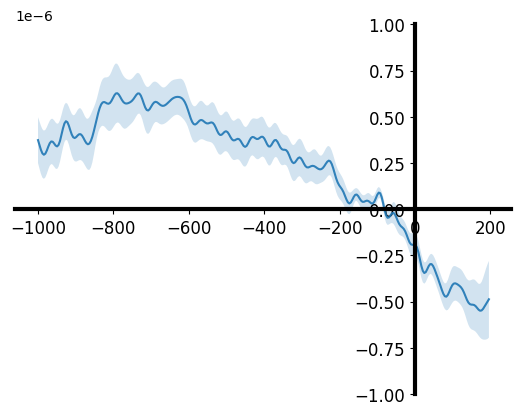

In [7]:
times = np.arange(-1000, 200, 1200/308)
y_min = -1e-6 
y_max = 1e-6  
plot_erp_results(erp_across_subjects, times, ylim=[y_min, y_max],labelpad=25)